In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append('../creme/')
import creme
import utils
import shutil
import pickle
import glob
import pandas as pd
import numpy as np
import itertools, os
from scipy.stats import pearsonr
from tqdm import tqdm

In [2]:

model_name = 'borzoi'
pdf_dir = utils.make_dir('pdf_dir')

threshold_enh, threshold_neu, threshold_sil = 0.7, 0.05, -0.3

In [3]:
target_df = pd.read_csv('../data/borzoi_targets_human.txt', sep='\t')
track_index = [i for i, t in enumerate(target_df['description']) if
       ('CAGE' in t) and (t.split(':')[-1].strip() in ['K562 ENCODE, biol_',
                                                       'GM12878 ENCODE, biol_',
                                                       'PC-3'])]
track_index

[298, 299, 870, 871, 872, 873]

In [4]:
cell_lines = ['K562 ENCODE, biol_', 'GM12878 ENCODE, biol_', 'PC-3']

In [5]:
cell_line_info = {}
for target_cell_line in cell_lines:
    cell_line_info[target_cell_line] = {}
    targets = [i for i, t in enumerate(target_df['description']) if
               ('CAGE' in t) and (t.split(':')[-1].strip() == target_cell_line)]
    
    
    cell_line_info[target_cell_line]['output'] = [np.argwhere(np.array(track_index) == t).flatten()[0] for t in
                                                  targets]
    cell_line_info[target_cell_line]['target'] = '&'.join([str(t) for t in targets])

In [46]:
res = []
for i, c in enumerate(cell_lines):
    selected_tss_path = glob.glob(f'../results/summary_csvs/enformer/*{c.split()[0]}*_selected_genes.csv')[0]
    cell_name = selected_tss_path.split('_')[-3]
    delta_means = []
    wt_means = []
    paths = []
    print(cell_name)
    selected_tss = pd.read_csv(selected_tss_path)
    for _, row in selected_tss.iterrows():
        
        r = f'../results/context_dependence_test_10/{model_name}/{utils.get_summary(row)}.pickle'
        with open(r, 'rb') as handle:
            context_res = pickle.load(handle)
        wt = context_res['wt'][:,cell_line_info[c]['output']].mean()
        mut = context_res['mut'][:,cell_line_info[c]['output']].mean()
        delta = (wt - mut) / wt
        delta_means.append(delta.mean())
        wt_means.append(wt.mean())
        paths.append(r)
        
    df = pd.DataFrame([delta_means, paths]).T
    df.columns = ['delta_mean', 'path']
    df['wt'] = wt_means
    df['context'] = [v for v in pd.cut(df['delta_mean'], 
                                       [df['delta_mean'].min()-1, threshold_sil, -threshold_neu, threshold_neu, threshold_enh, df['delta_mean'].max()+1], 
                           labels=['silencing', 'other1', 'neutral', 'other', 'enhancing']).values]
    df['cell_line'] = c.split()[0]
    
    print(df.shape)
    res.append(df)

res = pd.concat(res)
    

K562
(10000, 5)
GM12878
(10000, 5)
PC-3
(10000, 5)


In [32]:
res.to_csv(f'../results/context_dependence_test_10/{model_name}_result_summary.csv')

In [10]:
cell_line_info

{'K562 ENCODE, biol_': {'output': [4, 5], 'target': '872&873'},
 'GM12878 ENCODE, biol_': {'output': [2, 3], 'target': '870&871'},
 'PC-3': {'output': [0, 1], 'target': '298&299'}}

In [13]:
res

,delta_mean,path,wt,context,cell line
0,0.665527,../results/context_dependence_test_10/borzoi/P...,2.767578,other,K562
1,0.556641,../results/context_dependence_test_10/borzoi/A...,2.263672,other,K562
2,0.830078,../results/context_dependence_test_10/borzoi/D...,6.789062,enhancing,K562
3,0.538086,../results/context_dependence_test_10/borzoi/L...,0.112122,other,K562
4,0.608887,../results/context_dependence_test_10/borzoi/S...,4.125000,other,K562
...,...,...,...,...,...
9995,0.508789,../results/context_dependence_test_10/borzoi/C...,8.664062,other,PC-3
9996,0.696289,../results/context_dependence_test_10/borzoi/M...,12.703125,other,PC-3
9997,0.574219,../results/context_dependence_test_10/borzoi/H...,11.546875,other,PC-3
9998,0.595703,../results/context_dependence_test_10/borzoi/I...,9.085938,other,PC-3


In [ ]:
sns.set(font_scale = 1.1)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
for k, df in res.groupby('cell line'):
    
    fig = plt.figure(figsize=[10, 6])

    

    ax = sns.histplot(x=df['delta mean'], color='#5A0896')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel('Normalized TSS effect') # (WT - M) / WT
    # plt.xlim([-2,1.1])
    # plt.xticks([-2, -1, 0, 1])
    # plt.yticks([100, 200, 300])
    plt.title(f'Context Dependence Test {k} N={df.shape[0]}')
    # fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_hist.pdf', format='pdf', dpi=300, bbox_inches='tight')


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fb81c8a1ee0> (for post_execute):


(612, 6)
(750, 6)
(719, 6)
['enhancing (N=200)', 'neutral (N=200)', 'silencing (N=200)']
(1077, 6)
(475, 6)
(456, 6)
['enhancing (N=200)', 'neutral (N=200)', 'silencing (N=200)']
(227, 6)
(455, 6)
(186, 6)
['enhancing (N=200)', 'neutral (N=200)', 'silencing (N=186)']


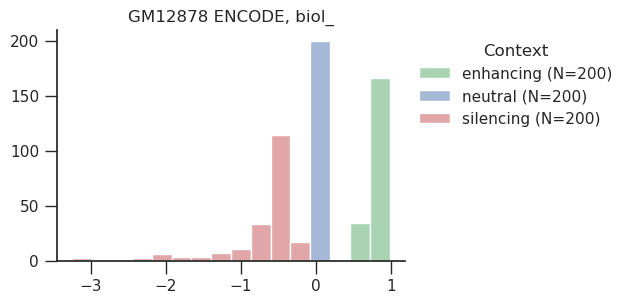

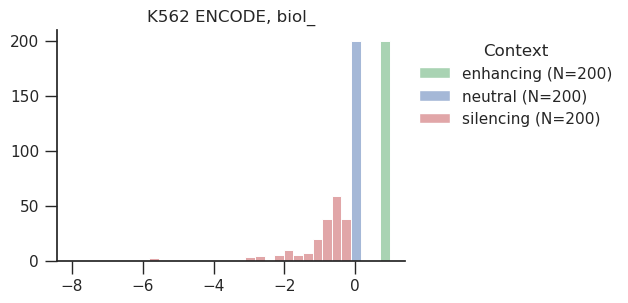

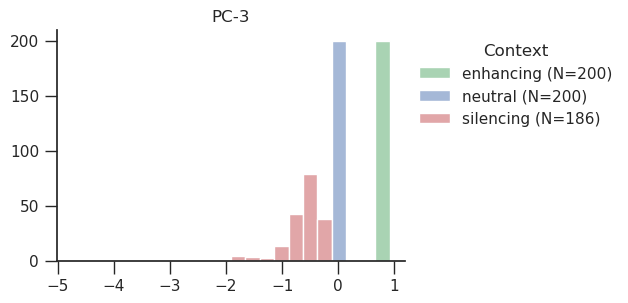

In [37]:
max_sample_size = 200
for k, df in res.groupby('cell line'):
    
    
    fig = plt.figure(figsize=[4.5, 3])
    sns.set(font_scale = 1.)
    sns.set_style(style='white')
    plt.rcParams['xtick.major.size'] = 9
    plt.rcParams['xtick.major.width'] = 1
    
    plt.rcParams['ytick.major.size'] = 9
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    context_df = df[(df['context']!='other') & (df['context']!='other1')]
    context_df_subsample = []
    for context_type, one_context_df in context_df.groupby('context'):
        print(one_context_df.shape)
        if one_context_df.shape[0] > max_sample_size:
            
            context_df_subsample.append(one_context_df.sample(max_sample_size, random_state=42))
        else:
            context_df_subsample.append(one_context_df)
    context_df = pd.concat(context_df_subsample)

    context_df = context_df.sort_values('context')
    ax = sns.histplot(data=context_df, 
                      x='delta mean', hue='context', 
                      hue_order=['enhancing', 'neutral', 'silencing'],
                      palette=['g', 'b', 'r'])
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.legend(frameon=False);
    legend = ax.get_legend()
    handles = legend.legend_handles
    legend.remove()
    labels = [f"{c} (N={s})" for _, (c, s) in context_df.groupby('context').count().reset_index().iloc[:,:2].iterrows() 
              if 'other' not in c]
    print(labels)
    ax.legend(handles, labels,
              title='Context', frameon=False, bbox_to_anchor=[1,1])
    
    plt.ylabel('')
    plt.xlabel('')
    
    plt.title(k)
    # plt.ylim(0,100)
    # plt.xlim([-2,1.1])
    # plt.yticks([0,50,100])
    fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_inset.pdf', format='pdf', dpi=300, bbox_inches='tight')
    context_df.to_csv(f'../results/summary_csvs//{model_name}/{k.split()[0]}_selected_contexts.csv')


In [25]:
cell_line_info[k]['output']

[2, 3]

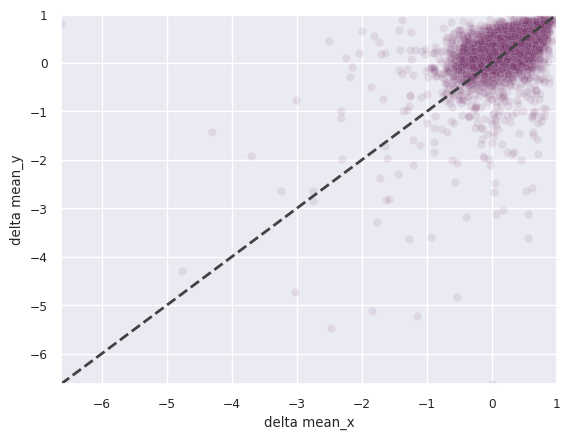

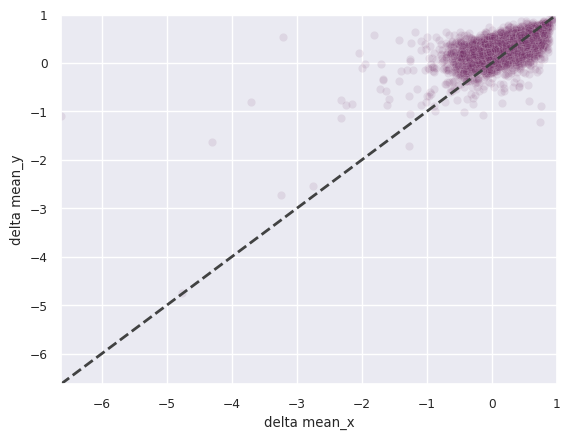

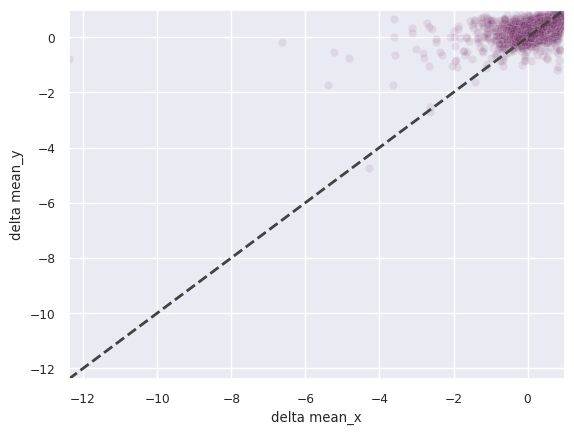

In [27]:
for df1, df2 in list(itertools.combinations([df for _, df  in res.groupby('cell line')], 2)):
    diff_comp = df1.merge(df2, on='path')
    sns.scatterplot(data=diff_comp, x='delta mean_x', y='delta mean_y', edgecolors=None, color='#702963', alpha=0.1)
    min_point = np.array(diff_comp['delta mean_x'], diff_comp['delta mean_y']).min()
    # add y=x line
    plt.plot([min_point,1],[min_point,1], lw=2, color='#414242', linestyle='dashed')
    # plt.xlabel(f'{c1} normalized TSS effect')
    # plt.ylabel(f'{c2} normalized TSS effect')
    plt.xlim(min_point,1)
    plt.ylim(min_point,1)
    plt.show()

# Compare enformer to borzoi

In [47]:
res['seq_id'] = [r.split('/')[-1].split('.')[0] for r in res['path']]

In [54]:
context_dependence_enformer = pd.read_csv('../results/summary_csvs/enformer/context_dependence_test.csv')
context_dependence_enformer['seq_id'] = [r.split('/')[-1].split('.')[0] for r in context_dependence_enformer['path']]
context_dependence_enformer = context_dependence_enformer.rename(columns={'cell line': 'cell_line'})

In [55]:
merged_results = context_dependence_enformer.merge(res, on=['seq_id', 'cell_line'], suffixes=['_enformer', '_borzoi'])

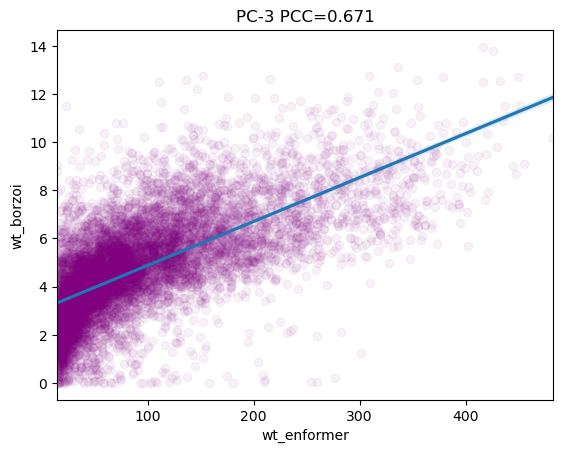

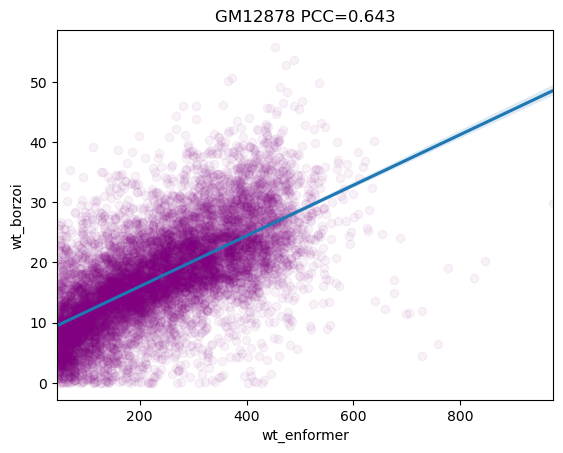

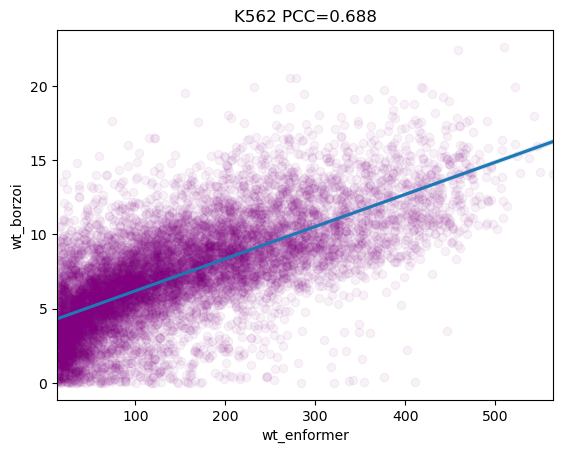

In [79]:
for cell_line in merged_results['cell_line'].unique():
    df = merged_results[merged_results['cell_line']==cell_line]
    pr = np.round(pearsonr(df['wt_enformer'], df['wt_borzoi'])[0], 3)
    sns.regplot(data=df, x='wt_enformer',
                    y='wt_borzoi', scatter_kws = {"alpha": 0.05, "edgecolor": 'purple', "color": 'purple'}
    )
    plt.title(f'{cell_line} PCC={pr}')
    plt.show()

In [130]:
filtered_df

,Unnamed: 0,delta_mean_enformer,path_enformer,wt_enformer,std,mean_mut,seq_id,context_enformer,cell_line,delta_mean_borzoi,path_borzoi,wt_borzoi,context_borzoi
10001,10001,0.208820,../results//context_dependence_test_100/enform...,45.340126,15.908402,35.872196,KCTD21_chr11_78188626_-,other,GM12878,0.324463,../results/context_dependence_test_10/borzoi/K...,7.390625,other
10002,10002,0.516094,../results//context_dependence_test_100/enform...,45.370094,6.857433,21.954870,MEGF8_chr19_42325608_+,other,GM12878,0.621582,../results/context_dependence_test_10/borzoi/M...,11.148438,other
10003,10003,0.556076,../results//context_dependence_test_100/enform...,45.383427,11.422747,20.146793,ACSF2_chr17_50426217_+,other,GM12878,0.740234,../results/context_dependence_test_10/borzoi/A...,10.343750,enhancing
10007,10007,0.251481,../results//context_dependence_test_100/enform...,45.532050,15.208086,34.081585,ASRGL1_chr11_62337447_+,other,GM12878,0.651855,../results/context_dependence_test_10/borzoi/A...,10.484375,other
10008,10008,0.557807,../results//context_dependence_test_100/enform...,45.577290,4.703366,20.153973,ZNF25_chr10_37976647_-,other,GM12878,0.71582,../results/context_dependence_test_10/borzoi/Z...,7.925781,enhancing
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19993,19993,0.899439,../results//context_dependence_test_100/enform...,728.052800,43.221855,73.213715,HLA-DQA1_chr6_32637405_+,other,GM12878,0.82959,../results/context_dependence_test_10/borzoi/H...,12.000000,enhancing
19996,19996,0.959561,../results//context_dependence_test_100/enform...,777.006600,22.088326,31.421211,HLA-DPA1_chr6_33073649_-,enhancing,GM12878,0.86377,../results/context_dependence_test_10/borzoi/H...,19.031250,enhancing
19997,19997,0.776071,../results//context_dependence_test_100/enform...,826.637100,53.822502,185.107800,HLA-DRA_chr6_32439886_+,other,GM12878,0.749512,../results/context_dependence_test_10/borzoi/H...,17.343750,enhancing
19998,19998,0.234555,../results//context_dependence_test_100/enform...,845.752440,24.238153,647.377300,LCP1_chr13_46182177_-,other,GM12878,0.5,../results/context_dependence_test_10/borzoi/L...,20.218750,other


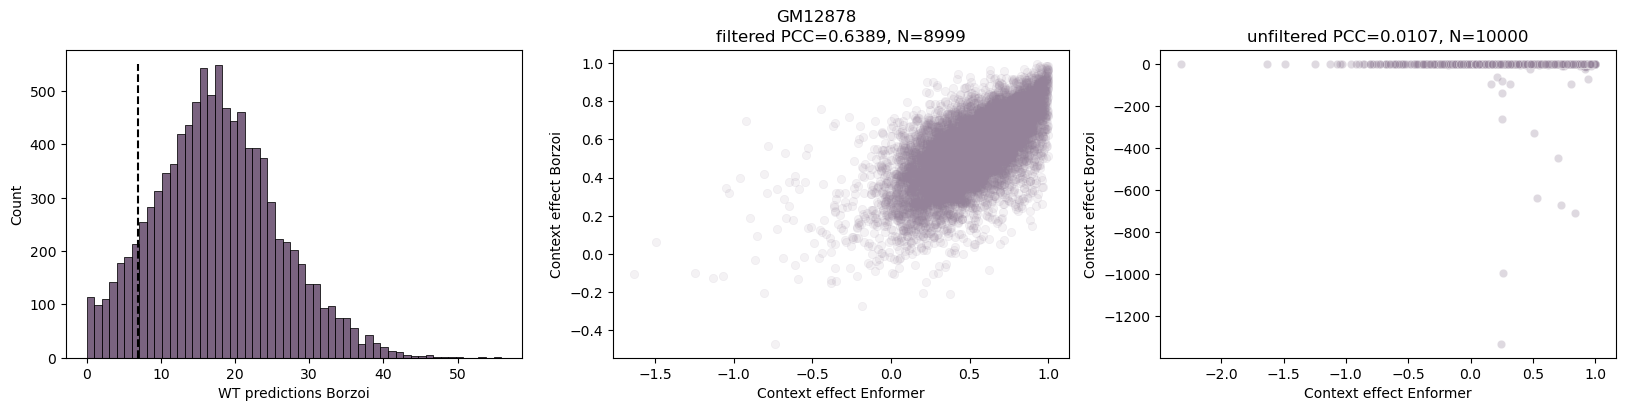

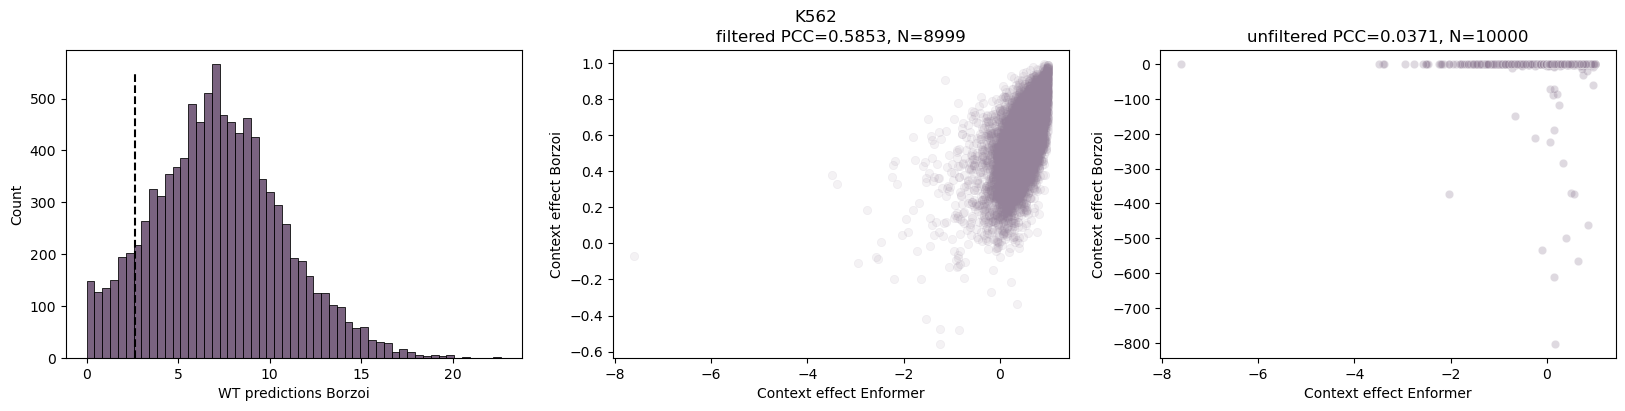

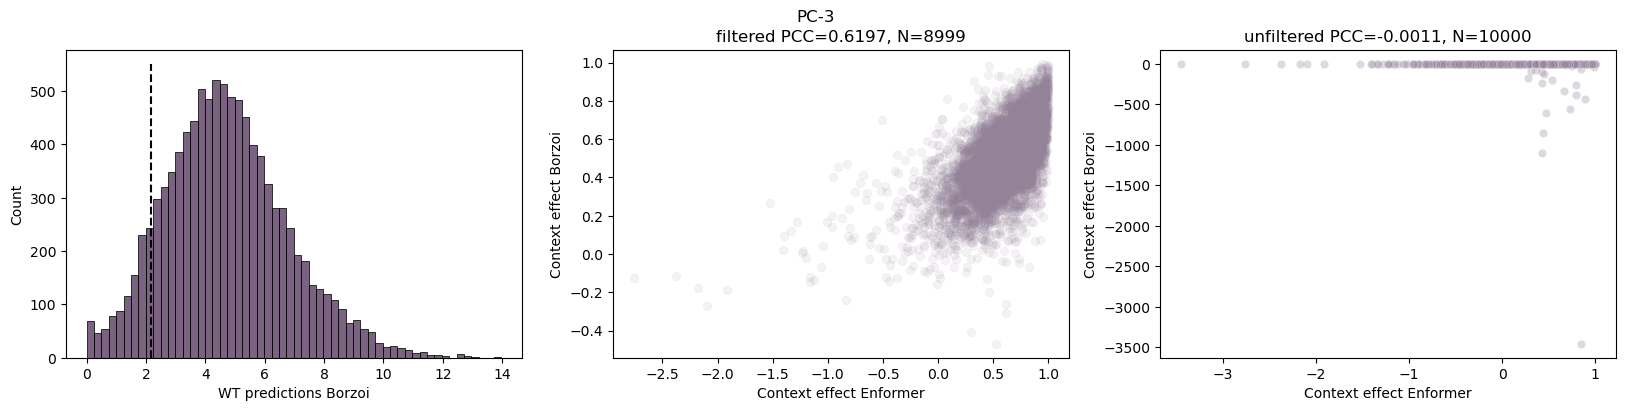

In [144]:
for cell, df in merged_results.groupby('cell_line'):
    fig, axes = plt.subplots(1, 3, figsize=[20, 4])
    borzoi_wt = df['wt_borzoi'].values.astype(float)
    sns.histplot(x=borzoi_wt, color='#4D2F56', ax=axes[0])
    threshold = np.quantile(borzoi_wt, 0.1)
    axes[0].vlines(threshold, 0, 550, color='k', linestyle='--')
    axes[0].set_xlabel('WT predictions Borzoi')
    plt.suptitle(cell)
    threshold = np.quantile(borzoi_wt, 0.1)
    filtered_df = df[df['wt_borzoi']>threshold]
    sns.scatterplot(data=filtered_df, x='delta_mean_enformer',
                    y='delta_mean_borzoi', ax=axes[1], edgecolor=None,
                    alpha = 0.1, color = '#948299')
    axes[1].set_xlabel('Context effect Enformer')
    axes[1].set_ylabel('Context effect Borzoi')
    pr = np.round(pearsonr(x=filtered_df['delta_mean_enformer'], y=filtered_df['delta_mean_borzoi'])[0], 4)
    axes[1].set_title(f'filtered PCC={pr}, N={filtered_df.shape[0]}')


    sns.scatterplot(data=df, x='delta_mean_enformer',
                    y='delta_mean_borzoi', ax=axes[2],
                    alpha = 0.3, color = '#948299')
    axes[2].set_xlabel('Context effect Enformer')
    axes[2].set_ylabel('Context effect Borzoi')
    pr = np.round(pearsonr(x=df['delta_mean_enformer'], y=df['delta_mean_borzoi'])[0], 4)
    axes[2].set_title(f'unfiltered PCC={pr}, N={df.shape[0]}')
    